# Exogenous Variables

Exogenous variables can provide additional information to greatly improve forecasting accuracy. Some examples include price or future promotions variables for demand forecasting, and weather data for electricity load forecast. In this notebook we show an example on how to add different types of exogenous variables to NeuralForecast models for making day-ahead hourly electricity price forecasts (EPF) for France and Belgium markets.

All NeuralForecast models are capable of incorporating exogenous variables to model the following conditional predictive distribution:
$$\mathbb{P}(\mathbf{y}_{t+1:t+H} \;|\; \mathbf{y}_{[:t]},\; \mathbf{x}^{(h)}_{[:t]},\; \mathbf{x}^{(f)}_{[:t+H]},\; \mathbf{x}^{(s)} )$$

where the regressors are static exogenous $\mathbf{x}^{(s)}$, historic exogenous $\mathbf{x}^{(h)}_{[:t]}$, exogenous available at the time of the prediction $\mathbf{x}^{(f)}_{[:t+H]}$ and autorregresive features $\mathbf{y}_{[:t]}$. Depending on the [train loss](https://nixtla.github.io/neuralforecast/losses.pytorch.html), the model outputs can be point forecasts (location estimators) or uncertainty intervals (quantiles).

We will show you how to include exogenous variables in the data, specify variables to a model, and produce forecasts using future exogenous variables.

:::{.callout-important}
This Guide assumes basic knowledge on the NeuralForecast library. For a minimal example visit the [Getting Started](../getting-started/02_quickstart.ipynb) guide.
:::

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/Exogenous_Variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Libraries

In [1]:
%%capture
!pip install neuralforecast

## 2. Load data

The `df` dataframe contains the target and exogenous variables past information to train the model. The `unique_id` column identifies the markets, `ds` contains the datestamps, and `y` the electricity price.

Include both historic and future temporal variables as columns. In this example, we are adding the system load (`system_load`) as historic data. For future variables, we include a forecast of how much electricity will be produced (`gen_forecast`) and day of week (`week_day`). Both the electricity system demand and offer impact the price significantly, including these variables to the model greatly improve performance, as we demonstrate in Olivares et al. (2022).

The distinction between historic and future variables will be made later as parameters of the model.

In [35]:
import pandas as pd
from utilsforecast.plotting import plot_series

In [36]:
df = pd.read_csv(
    #'https://datasets-nixtla.s3.amazonaws.com/EPF_FR_BE.csv',
    '/content/Hourly_Mexico_Data.csv',
    parse_dates=['date'],
)
df = df.drop(columns=['active_power',	'voltage',	'power_factor',	'pressure',	'humidity', 'speed', 'Day',	'Hour_of_the_Day', 'Month',	'DayOfWeek','Weekday/Weekend','Season' ])
# Preprocessing: Rename date and target columns for compatibility with NeuralForecast
df['ds'] = df['date']  # Rename date column to 'ds' for compatibility
df['y'] = df['active_power_kW']  # Rename the target column to 'y' for compatibility
# Sort the dataset by 'unique_id' and 'ds' (if applicable, assuming hierarchical structure)
def sort_df_hier(Y_df):
    Y_df['unique_id'] = Y_df['unique_id'].astype('category')  # Ensure unique_id is categorical
    Y_df = Y_df.sort_values(by=['unique_id', 'ds'])  # Sort by unique_id and datetime
    return Y_df

# Assuming a single time series, you can set a single unique_id for this example
df['unique_id'] = 'A'  # Use a single unique ID for simplicity

Y_df = sort_df_hier(df)
df = df.drop(columns=['date','active_power_kW'])
df.head()

,reactive_power,temp,ds,y,unique_id
0,6988.65,24.246364,2022-11-05 14:00:00,13.6829,A
1,8212.41,24.302000,2022-11-05 15:00:00,12.1598,A
2,6973.07,24.174000,2022-11-05 16:00:00,11.9318,A
3,12146.17,23.485667,2022-11-05 17:00:00,23.4109,A
4,8629.68,21.693667,2022-11-05 18:00:00,26.5822,A


:::{.callout-tip}
Calendar variables such as day of week, month, and year are very useful to capture long seasonalities.
:::

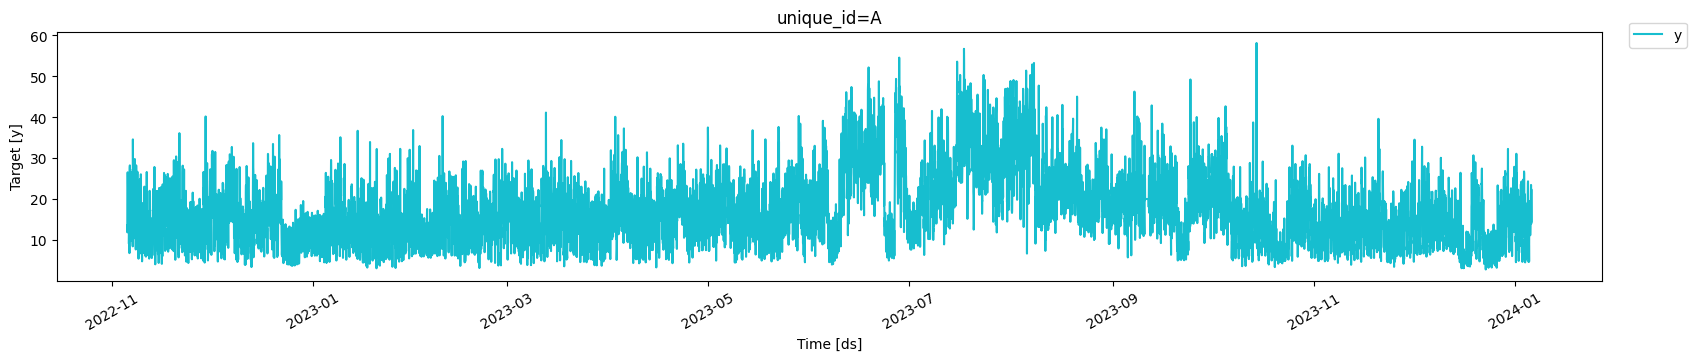

In [37]:
plot_series(df)

Add the static variables in a separate `static_df` dataframe. In this example, we are using one-hot encoding of the electricity market. The `static_df` must include one observation (row) for each `unique_id` of the `df` dataframe, with the different statics variables as columns.

In [22]:
#static_df = pd.read_csv('/content/Hourly_Mexico_Data.csv_static.csv')
#static_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/Hourly_Mexico_Data.csv_static.csv'

## 3. Training with exogenous variables


We distinguish the exogenous variables by whether they reflect static or time-dependent aspects of the modeled data.

* **Static exogenous variables**:
The static exogenous variables carry time-invariant information for each time series. When the model is built with global parameters to forecast multiple time series, these variables allow sharing information within groups of time series with similar static variable levels. Examples of static variables include designators such as identifiers of regions, groups of products, etc.

* **Historic exogenous variables**:
This time-dependent exogenous variable is restricted to past observed values. Its predictive power depends on Granger-causality, as its past values can provide significant information about future values of the target variable $\mathbf{y}$.

* **Future exogenous variables**:
In contrast with historic exogenous variables, future values are available at the time of the prediction. Examples include calendar variables, weather forecasts, and known events that can cause large spikes and dips such as scheduled promotions.

To add exogenous variables to the model, first specify the name of each variable from the previous dataframes to the corresponding model hyperparameter during initialization: `futr_exog_list`, `hist_exog_list`, and `stat_exog_list`. We also set `horizon` as 24 to produce the next day hourly forecasts, and set `input_size` to use the last 5 days of data as input.  

In [38]:
import logging

from neuralforecast.auto import NHITS, BiTCN
from neuralforecast.core import NeuralForecast

In [39]:
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [40]:
horizon = 24 # day-ahead daily forecast
models = [NHITS(h = horizon,
                max_steps=100,
                input_size = 5*horizon,
                futr_exog_list = ['reactive_power'], # <- Future exogenous variables
                hist_exog_list = ['temp'], # <- Historical exogenous variables
                #stat_exog_list = ['market_0', 'market_1'], # <- Static exogenous variables
                scaler_type = 'robust'),
          BiTCN(h = horizon,
                input_size = 5*horizon,
                max_steps=100,
                futr_exog_list = ['reactive_power'], # <- Future exogenous variables
                hist_exog_list = ['temp'], # <- Historical exogenous variables
                #stat_exog_list = ['market_0', 'market_1'], # <- Static exogenous variables
                scaler_type = 'robust',
                ),
                ]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


:::{.callout-tip}
When including exogenous variables always use a scaler by setting the `scaler_type` hyperparameter. The scaler will scale all the temporal features: the target variable `y`, historic and future variables.
:::

:::{.callout-important}
Make sure future and historic variables are correctly placed. Defining historic variables as future variables will lead to data leakage.
:::

Next, pass the datasets to the `df` and `static_df` inputs of the `fit` method.

In [41]:
nf = NeuralForecast(models=models, freq='h')
nf.fit(df=df) #static_df=static_df)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## 4. Forecasting with exogenous variables

Before predicting the prices, we need to gather the future exogenous variables for the day we want to forecast. Define a new dataframe (`futr_df`) with the `unique_id`, `ds`, and future exogenous variables. There is no need to add the target variable `y` and historic variables as they won't be used by the model.

In [51]:
# Step 1: Generate future time steps (after the training period)
futr_steps = horizon  # The number of future periods you want to forecast

# Assuming the last time in the original dataset (test data) is the starting point for future data
last_time = df['ds'].max()  # Get the last datetime from the training data

# Generate future dates (next `horizon` periods)
future_dates = pd.date_range(last_time, periods=futr_steps + 1, freq='D')[1:]  # Get future dates excluding the last one

# Get the last row (most recent observation) of the dataset
last_row = df.iloc[-1]

# Step 2: Create a future DataFrame (`futr_df`) with future exogenous variables
futr_df = pd.DataFrame({
    'ds': future_dates,  # The future dates
    'reactive_power': [last_row['reactive_power']] * futr_steps,  # Use the last value of `reactive_power`
    'temp': [last_row['temp']] * futr_steps,  # Use the last value of `temp`
    # 'active_power_kW': [last_row['active_power_kW']] * futr_steps,  # You can comment out since you're forecasting `active_power_kW`
})

# Add the `unique_id` column (assuming you're working with a single time series)
futr_df['unique_id'] = 'A'  # Use 'A' as a unique ID for a single time series

# Step 3: Use the `make_future_dataframe` method to generate the expected `futr_df`
# This will automatically handle the correct frequency (daily in this case) based on the provided `ds` column
futr_df = nf.make_future_dataframe(df=futr_df)

# Step 4: Use the `NeuralForecast` object (assuming it's defined as `nf`)
Y_hat_df = nf.predict(futr_df=futr_df)

# Step 5: View the forecasted values
Y_hat_df.head()  # Show the top rows of the forecasted data

ValueError: The following features are missing from `futr_df`: {'reactive_power'}

In [46]:
# Step 1: Generate future time steps (after the training period)
# Let's assume you want to forecast for the next `horizon` periods (12 time steps, for example)
futr_steps = horizon  # The number of future periods you want to forecast

# Assuming the last time in the original dataset (test data) is the starting point for future data
last_time = df['ds'].max()  # Get the last datetime from the training data

# Generate future dates (next `horizon` periods)
future_dates = pd.date_range(last_time, periods=futr_steps + 1, freq='D')[1:]  # Get future dates excluding the last one

last_row = df.iloc[-1]

# Example: Create a future DataFrame (`futr_df`) with future exogenous variables
futr_df = pd.DataFrame({
    'ds': future_dates,  # The future dates
    'reactive_power': [last_row['reactive_power']] * futr_steps,  # Use the last value of `reactive_power`
    'temp': [last_row['temp']] * futr_steps,  # Use the last value of `temp`
    'active_power_kW': [last_row['active_power_kW']] * futr_steps,  # Use the last value of `active_power_kW`
})

# Step 3: Use the `NeuralForecast` object (assuming it's defined as `nf`)
Y_hat_df = nf.predict(futr_df=futr_df)

# Step 4: View the forecasted values
Y_hat_df.head()  # Show the top rows of the forecasted data

KeyError: 'active_power_kW'

:::{.callout-important}
Make sure `futr_df` has informations for the entire forecast horizon. In this example, we are forecasting 24 hours ahead, so `futr_df` must have 24 rows for each time series.
:::

Finally, use the `predict` method to forecast the day-ahead prices.

In [33]:
Y_hat_df = nf.predict(futr_df=futr_df)
Y_hat_df.head()

ValueError: The following features are missing from `futr_df`: {'reactive_power'}

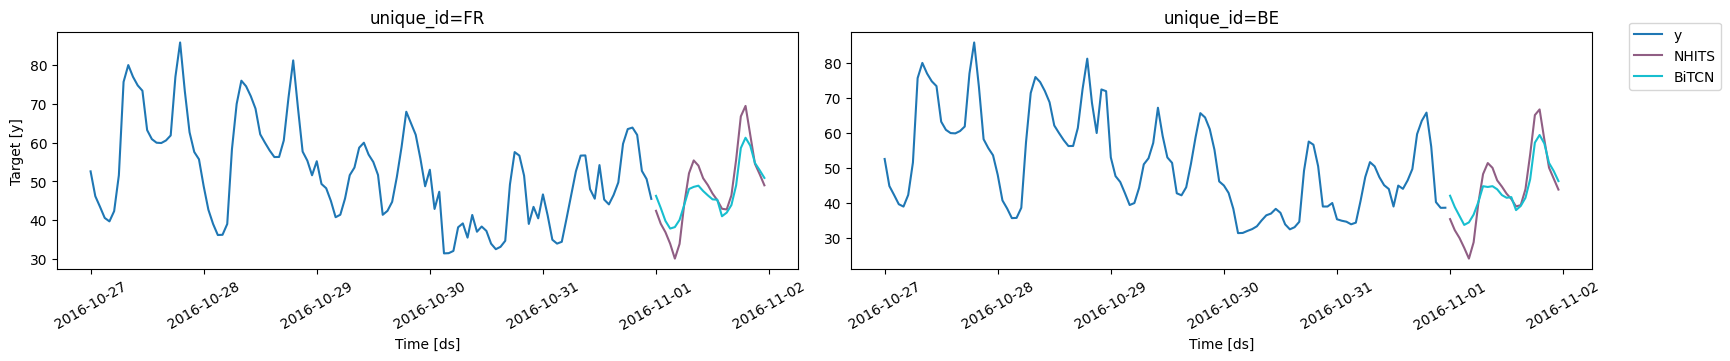

In [12]:
plot_series(df, Y_hat_df, max_insample_length=24*5)

In summary, to add exogenous variables to a model make sure to follow the next steps:

1. Add temporal exogenous variables as columns to the main dataframe (`df`).
2. Add static exogenous variables with the `static_df` dataframe.
3. Specify the name for each variable in the corresponding model hyperparameter.
4. If the model uses future exogenous variables, pass the future dataframe (`futr_df`) to the `predict` method.

## References

- [Kin G. Olivares, Cristian Challu, Grzegorz Marcjasz, Rafał Weron, Artur Dubrawski, Neural basis expansion analysis with exogenous variables: Forecasting electricity prices with NBEATSx, International Journal of Forecasting](https://www.sciencedirect.com/science/article/pii/S0169207022000413)

- [Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2021). NHITS: Neural Hierarchical Interpolation for Time Series Forecasting. Accepted at AAAI 2023.](https://arxiv.org/abs/2201.12886)